In [1]:
import pickle
from collections import deque

import gym
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
from running_mean_std import RunningMeanStd

In [2]:
# class ActorCriticNet(nn.Module):
#     def __init__(self, obs_space, action_space):
#         super().__init__()
#         h = 64
#         self.head = nn.Sequential(nn.Linear(obs_space, h), nn.Tanh())
#         self.pol = nn.Sequential(nn.Linear(h, h), nn.Tanh(), nn.Linear(h, action_space))
#         self.val = nn.Sequential(nn.Linear(h, h), nn.Tanh(), nn.Linear(h, 1))
#         self.log_softmax = nn.LogSoftmax(dim=-1)

#     def forward(self, x):
#         out = self.head(x)
#         logit = self.pol(out).reshape(out.shape[0], -1)
#         log_p = self.log_softmax(logit)
#         v = self.val(out).reshape(out.shape[0], 1)

#         return log_p, v

In [3]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space, use_obs_norm=True):
        super().__init__()
        h = 64
        self.use_obs_norm = use_obs_norm
        self.obs_space = obs_space
        self.obs_norms = nn.ModuleList([nn.BatchNorm1d(1, momentum=None, affine=False) for _ in range(obs_space)])
        self.pol = nn.Sequential(
            nn.Linear(obs_space, h, bias=True),
            nn.Tanh(),
            nn.Linear(h, action_space, bias=True),
        )
        self.val = nn.Sequential(
            nn.Linear(obs_space, h, bias=True),
            nn.Tanh(),
            nn.Linear(h, 1, bias=True),
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        if self.use_obs_norm:
            norm_x = []
            for norm, obs in zip(self.obs_norms, x.chunk(chunks=self.obs_space, dim=1)):
                norm_x.append(norm(obs))
            x = torch.concat(norm_x, dim=1)
        logit = self.pol(x).reshape(x.shape[0], -1)
        log_p = self.log_softmax(logit)
        v = self.val(x).reshape(x.shape[0], 1)

        return log_p, v

In [4]:
def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item(), v.item()

## Main

In [5]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make("CartPole-v1", render_mode="rgb_array")
# env = gym.make("MountainCar-v0", render_mode="rgb_array")
env = gym.make("LunarLander-v2", render_mode="rgb_array")
SEED = 0
# env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

OBS_NORM = False
n_episodes = 10000
# n_eval = env.spec.trials
n_eval = 10

# global values
total_steps = 0
obses = []
rewards = []
reward_eval = deque(maxlen=n_eval)

# load a model
old_net = ActorCriticNet(obs_space, action_space, use_obs_norm=False).to(device)
old_net.load_state_dict(torch.load("./saved_models/LunarLander-v2_ep6433_clear_model_ppo_st.pt"))
old_net.eval()
# with open('./saved_models/CartPole-v1_up36_clear_norm_obs.pkl', 'rb') as f:
#      norm_obs = pickle.load(f)

<ipython-input-5-57fdcd90b39b>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  old_net.load_state_dict(torch.load("./saved_models/LunarLander-v2_ep6433_clear_model_ppo_st.

ActorCriticNet(
  (obs_norms): ModuleList(
    (0-7): 8 x BatchNorm1d(1, eps=1e-05, momentum=None, affine=False, track_running_stats=True)
  )
  (pol): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
  (val): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (log_softmax): LogSoftmax(dim=-1)
)

In [6]:
env.render_mode

'rgb_array'

In [7]:
env.render_mode

'rgb_array'

In [8]:
env.spec.max_episode_steps

1000

In [9]:
env.spec.reward_threshold

200

In [10]:
# play
for i in range(1, n_episodes + 1):
    frames = []
    obs, _ = env.reset()
    done = False
    timeout = False
    ep_reward = 0
    ep_steps = 0
    while not (done or timeout):
        frames.append(env.render())
        env.render()
        if OBS_NORM:
            obs_norm = np.clip((obs - norm_obs.mean) / np.sqrt(norm_obs.var + 1e-8), -10, 10)
            action, _ = get_action_and_value(obs_norm, old_net)
        else:
            action, _ = get_action_and_value(obs, old_net)

        _obs, reward, done, _, _ = env.step(action)
        obs = _obs
        total_steps += 1
        ep_steps += 1
        ep_reward += reward
        timeout = ep_steps >= 1000

    if done or timeout:
        # env.render()
        if OBS_NORM:
            norm_obs.update(_obs)
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print("{:3} Episode in {:5} steps, reward {:.2f}".format(i, total_steps, ep_reward))
        frames.append(env.render())
        if ep_reward >= env.spec.reward_threshold:
            imageio.mimsave(
                f"{env.spec.id}_reward{ep_reward}.gif",
                frames,
            )

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print("\n{} is sloved! {:3} Episode in {:3} steps".format(env.spec.id, i, total_steps))
                print(np.mean(reward_eval))
                break
env.close()

<ipython-input-4-0d04513f77d6>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  state = torch.tensor([obs]).to(device).float()
/Users/jdkim/miniconda3/envs/gym/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


  1 Episode in   239 steps, reward 272.29
  2 Episode in   516 steps, reward 263.64
  3 Episode in  1344 steps, reward 217.43
  4 Episode in  1586 steps, reward 259.54
  5 Episode in  2182 steps, reward 241.75
  6 Episode in  2378 steps, reward 69.52
  7 Episode in  2724 steps, reward 254.85
  8 Episode in  2983 steps, reward 259.28
  9 Episode in  3247 steps, reward 264.41
 10 Episode in  3510 steps, reward 297.65

LunarLander-v2 is sloved!  10 Episode in 3510 steps
240.03681876622954


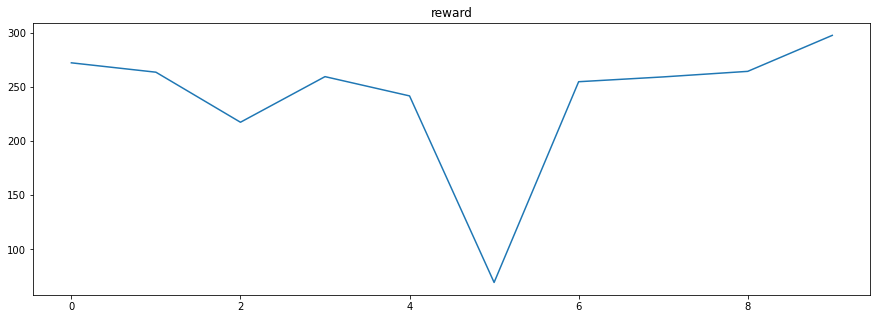

In [11]:
plt.figure(figsize=(15, 5))
plt.title("reward")
plt.plot(rewards)
plt.show()

In [12]:
[("CartPole-v0", 412, 1), ("CartPole-v1", 452, 0.05), ("MountainCar-v0", 193, 0.1), ("LunarLander-v2", 260, 0.1)]

[('CartPole-v0', 412, 1),
 ('CartPole-v1', 452, 0.05),
 ('MountainCar-v0', 193, 0.1),
 ('LunarLander-v2', 260, 0.1)]